In [5]:
#Random forest
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from scipy.stats import pearsonr

import csv
import pandas as pd
import numpy as np

import pydotplus
from six import StringIO
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
plt.rcParams['figure.dpi'] = 360

In [6]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'../data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.append(float(values[1]))
                n.extend(22.5-2.5*np.log10([float(n) for n in values[2:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'../data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [7]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = X_train, X_test, y_train, y_test
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_pred_rf = y_pred
#model.score(X_test, y_pred)
r2, mse, pc = 1, mean_squared_error(y_test, y_pred), pearsonr(y_test, y_pred).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

R^2: 1
mse: 0.035719688968561494
Pearson correlation: 0.9507515018830839


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.282464 to fit



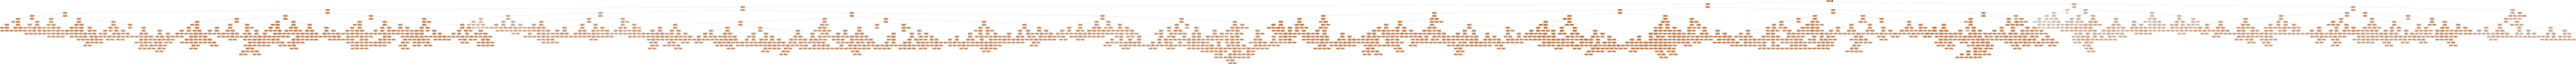

In [8]:
tree = regressor.estimators_[0]

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

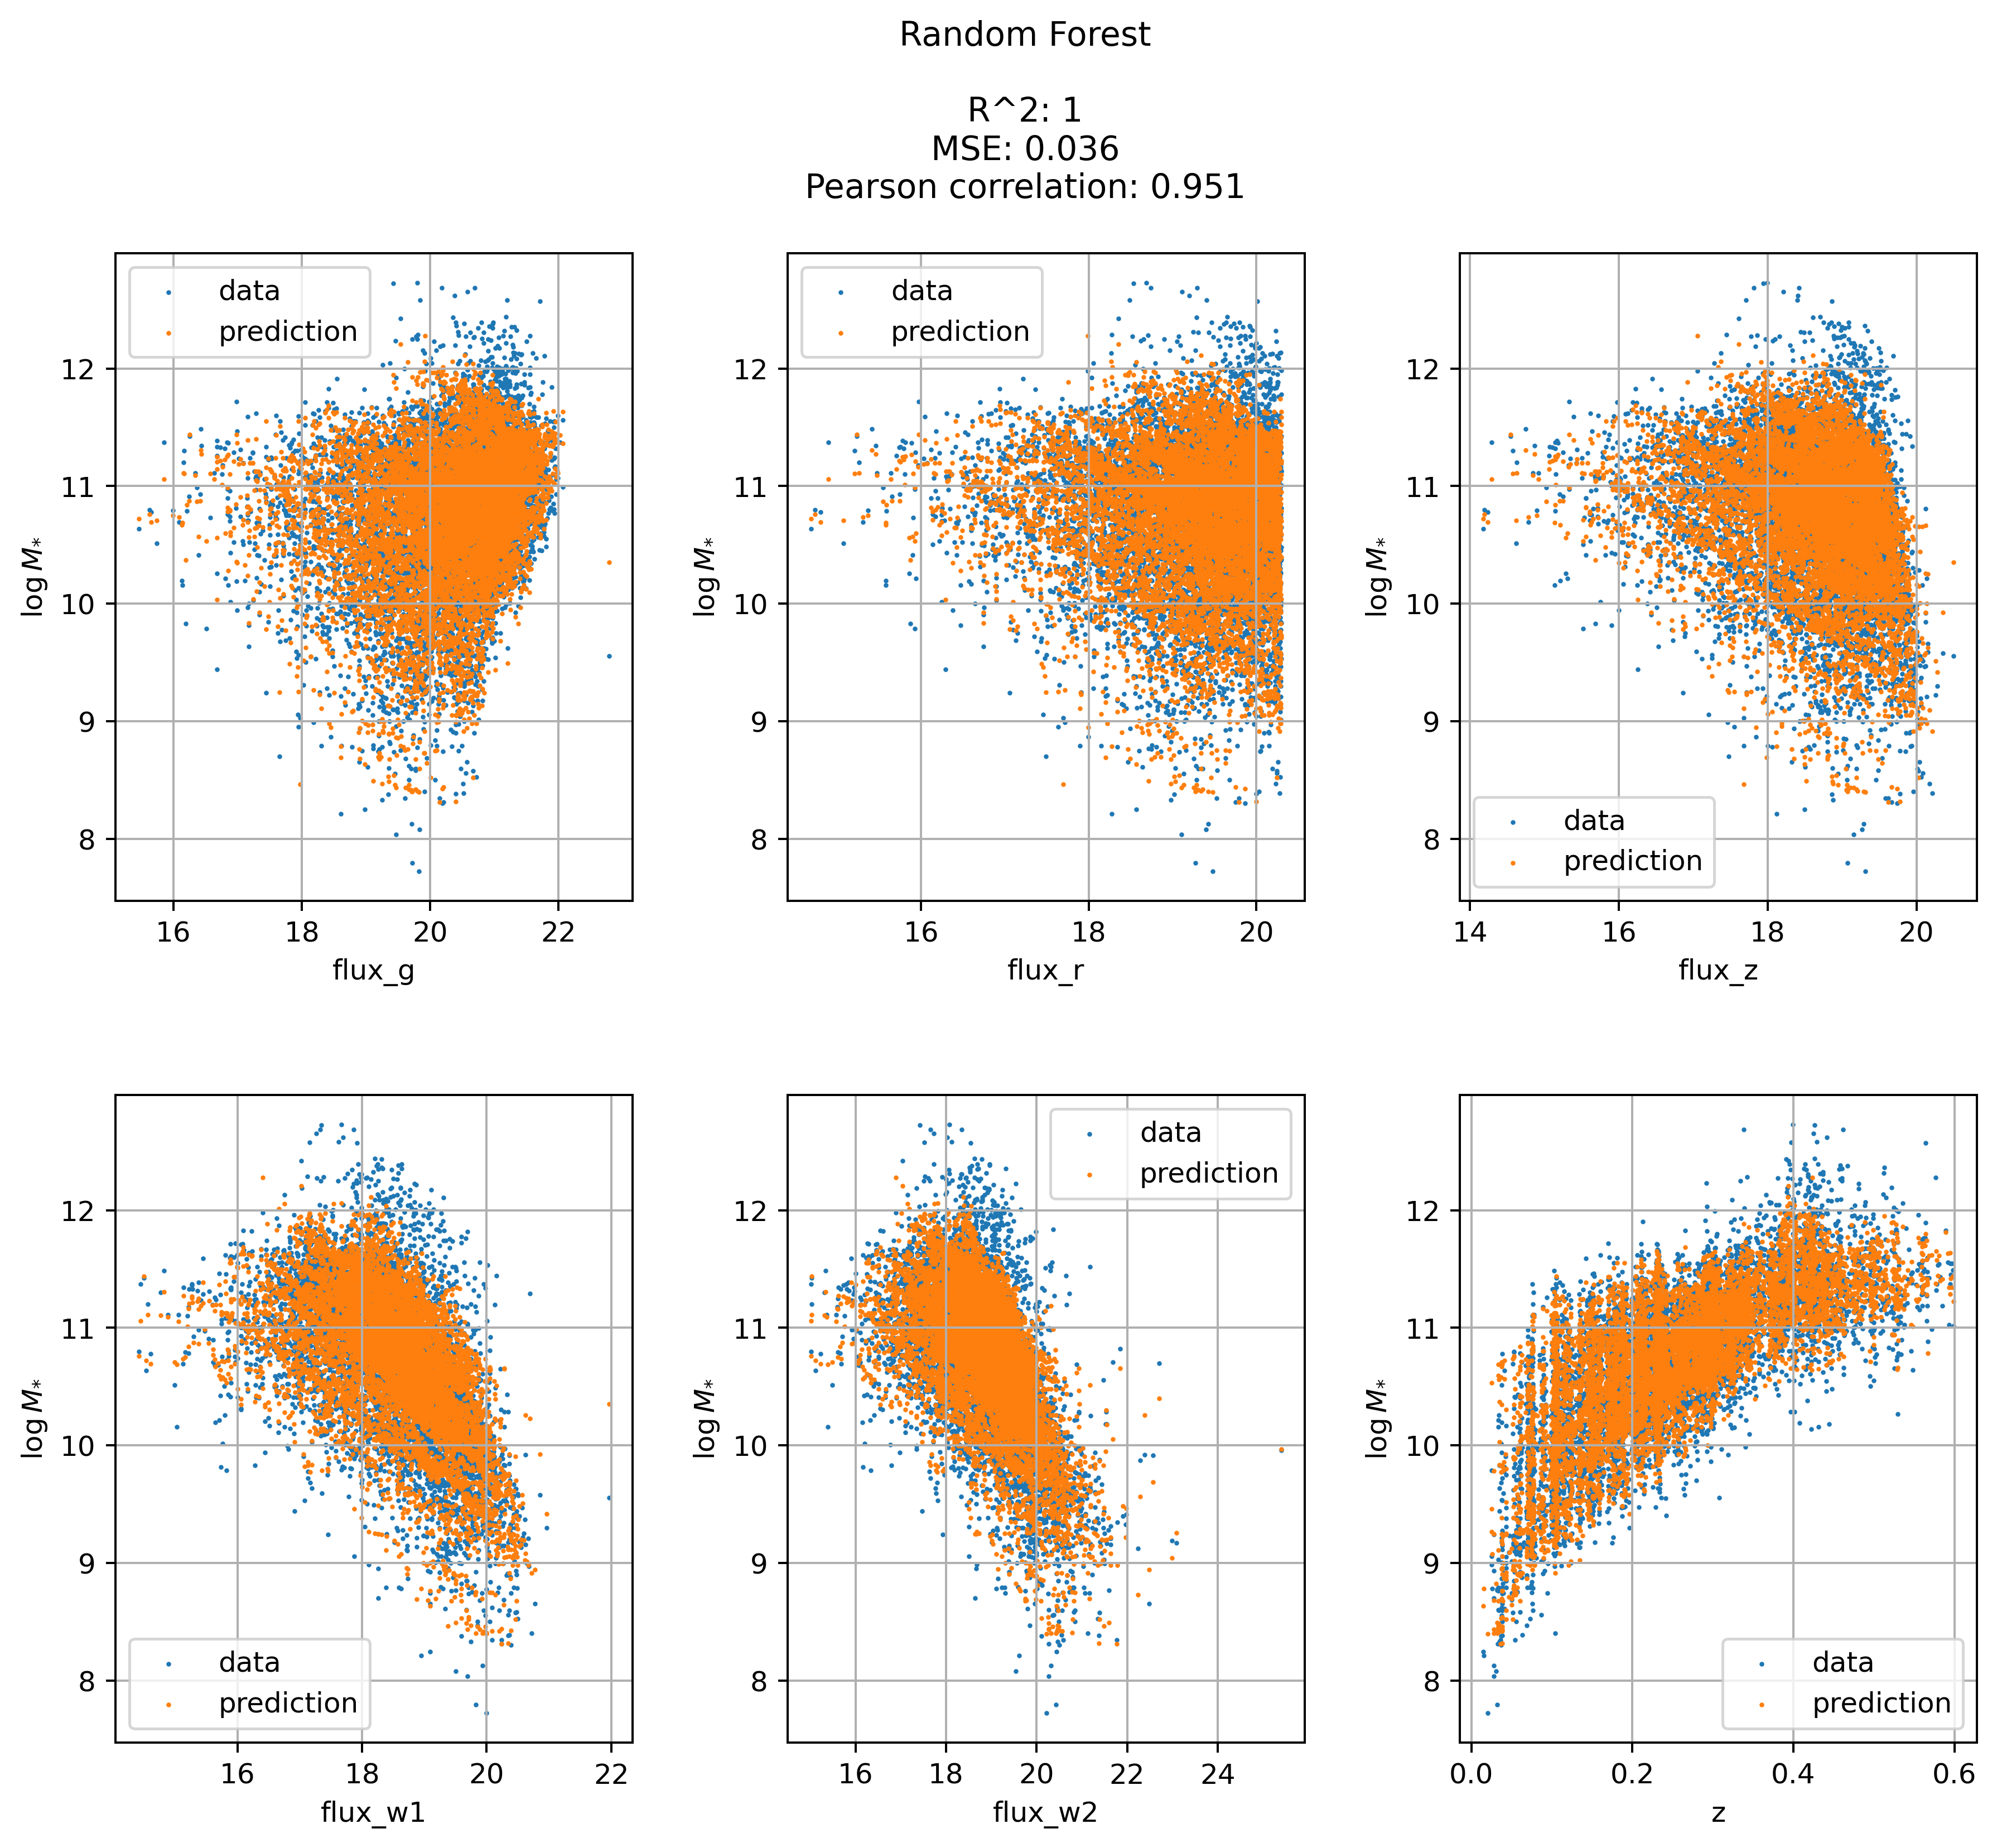

In [9]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(f'Random Forest\n \nR^2: {round(r2,3)}\nMSE: {round(mse,3)}\nPearson correlation: {round(pc,3)}', y=1.12)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(ncols):
    for j in range(nrows):
        axes[i, j].scatter(X_test[:,i*3+j], y_test, s=0.5, label='data')
        axes[i, j].scatter(X_test[:,i*3+j], y_pred, s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_ylabel(r'$\log M_{*}$')
        axes[i, j].set_xlabel(f'{labels[i*3+j]}')
        axes[i, j].grid()

plt.show()

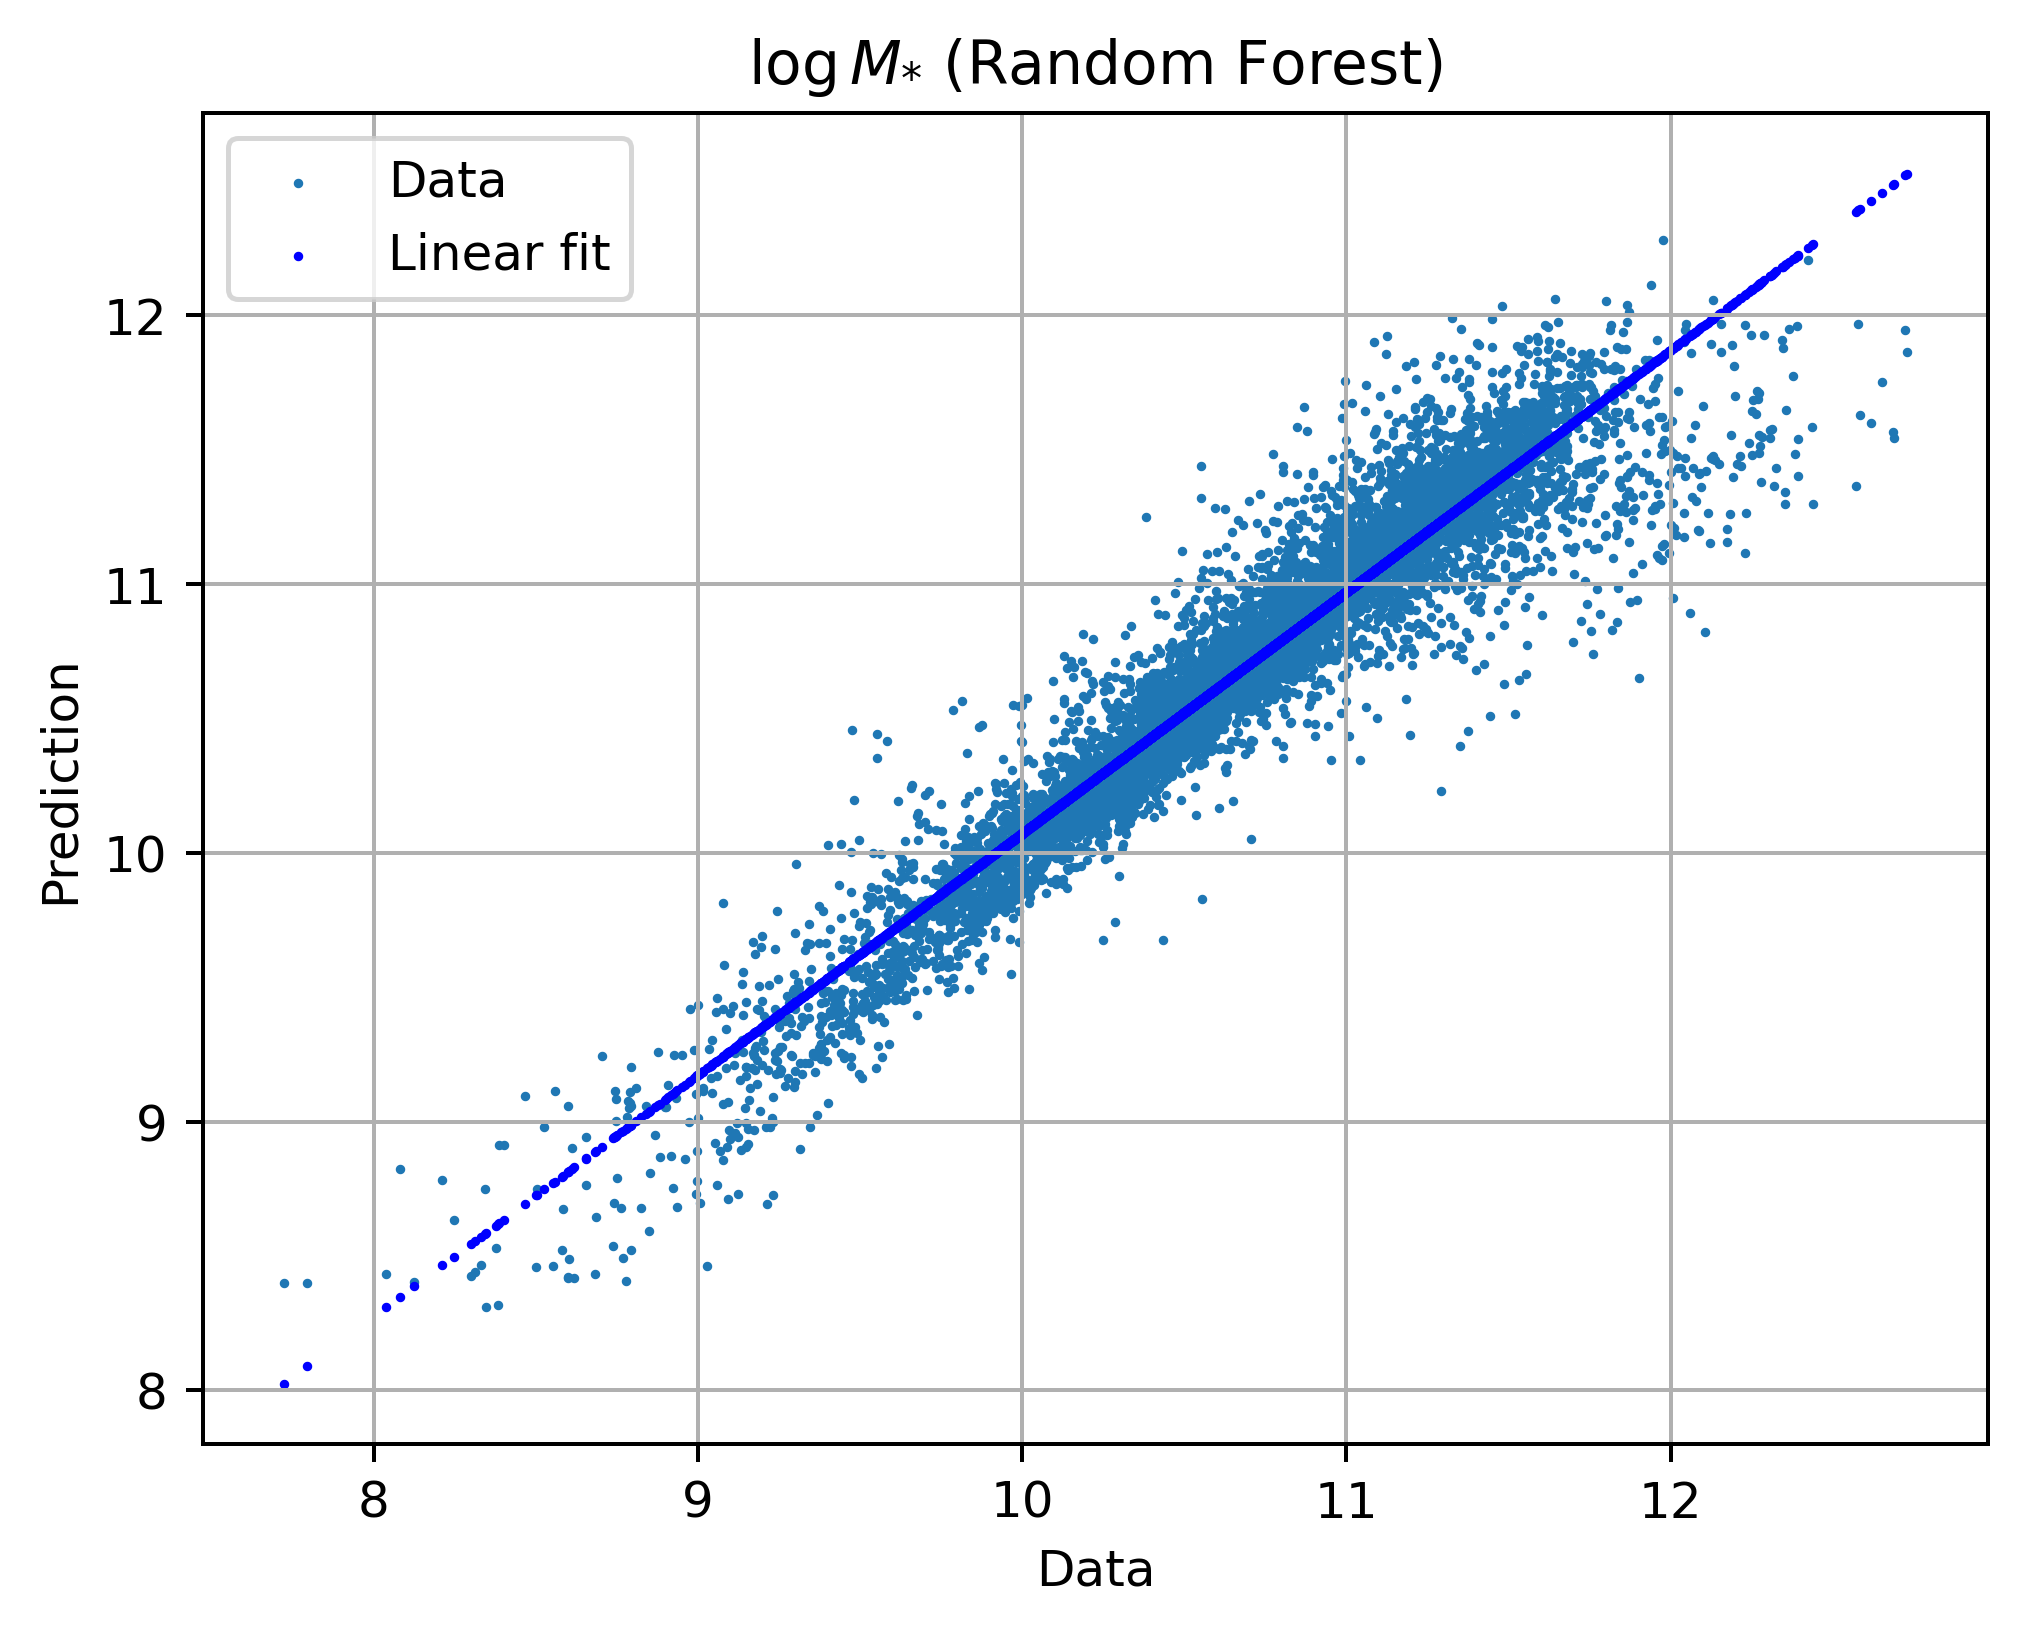

In [10]:
slope, intercept = np.polyfit(y_test, y_pred, 1)
r = slope*y_test+intercept

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, s=0.8)
ax.scatter(y_test, r, color='b', s=0.8)
ax.set_ylabel('Prediction')
ax.set_xlabel('Data')
plt.title(r'$\log M_{*}$ (Random Forest)')
plt.legend(['Data', 'Linear fit'])
plt.grid()
plt.show()

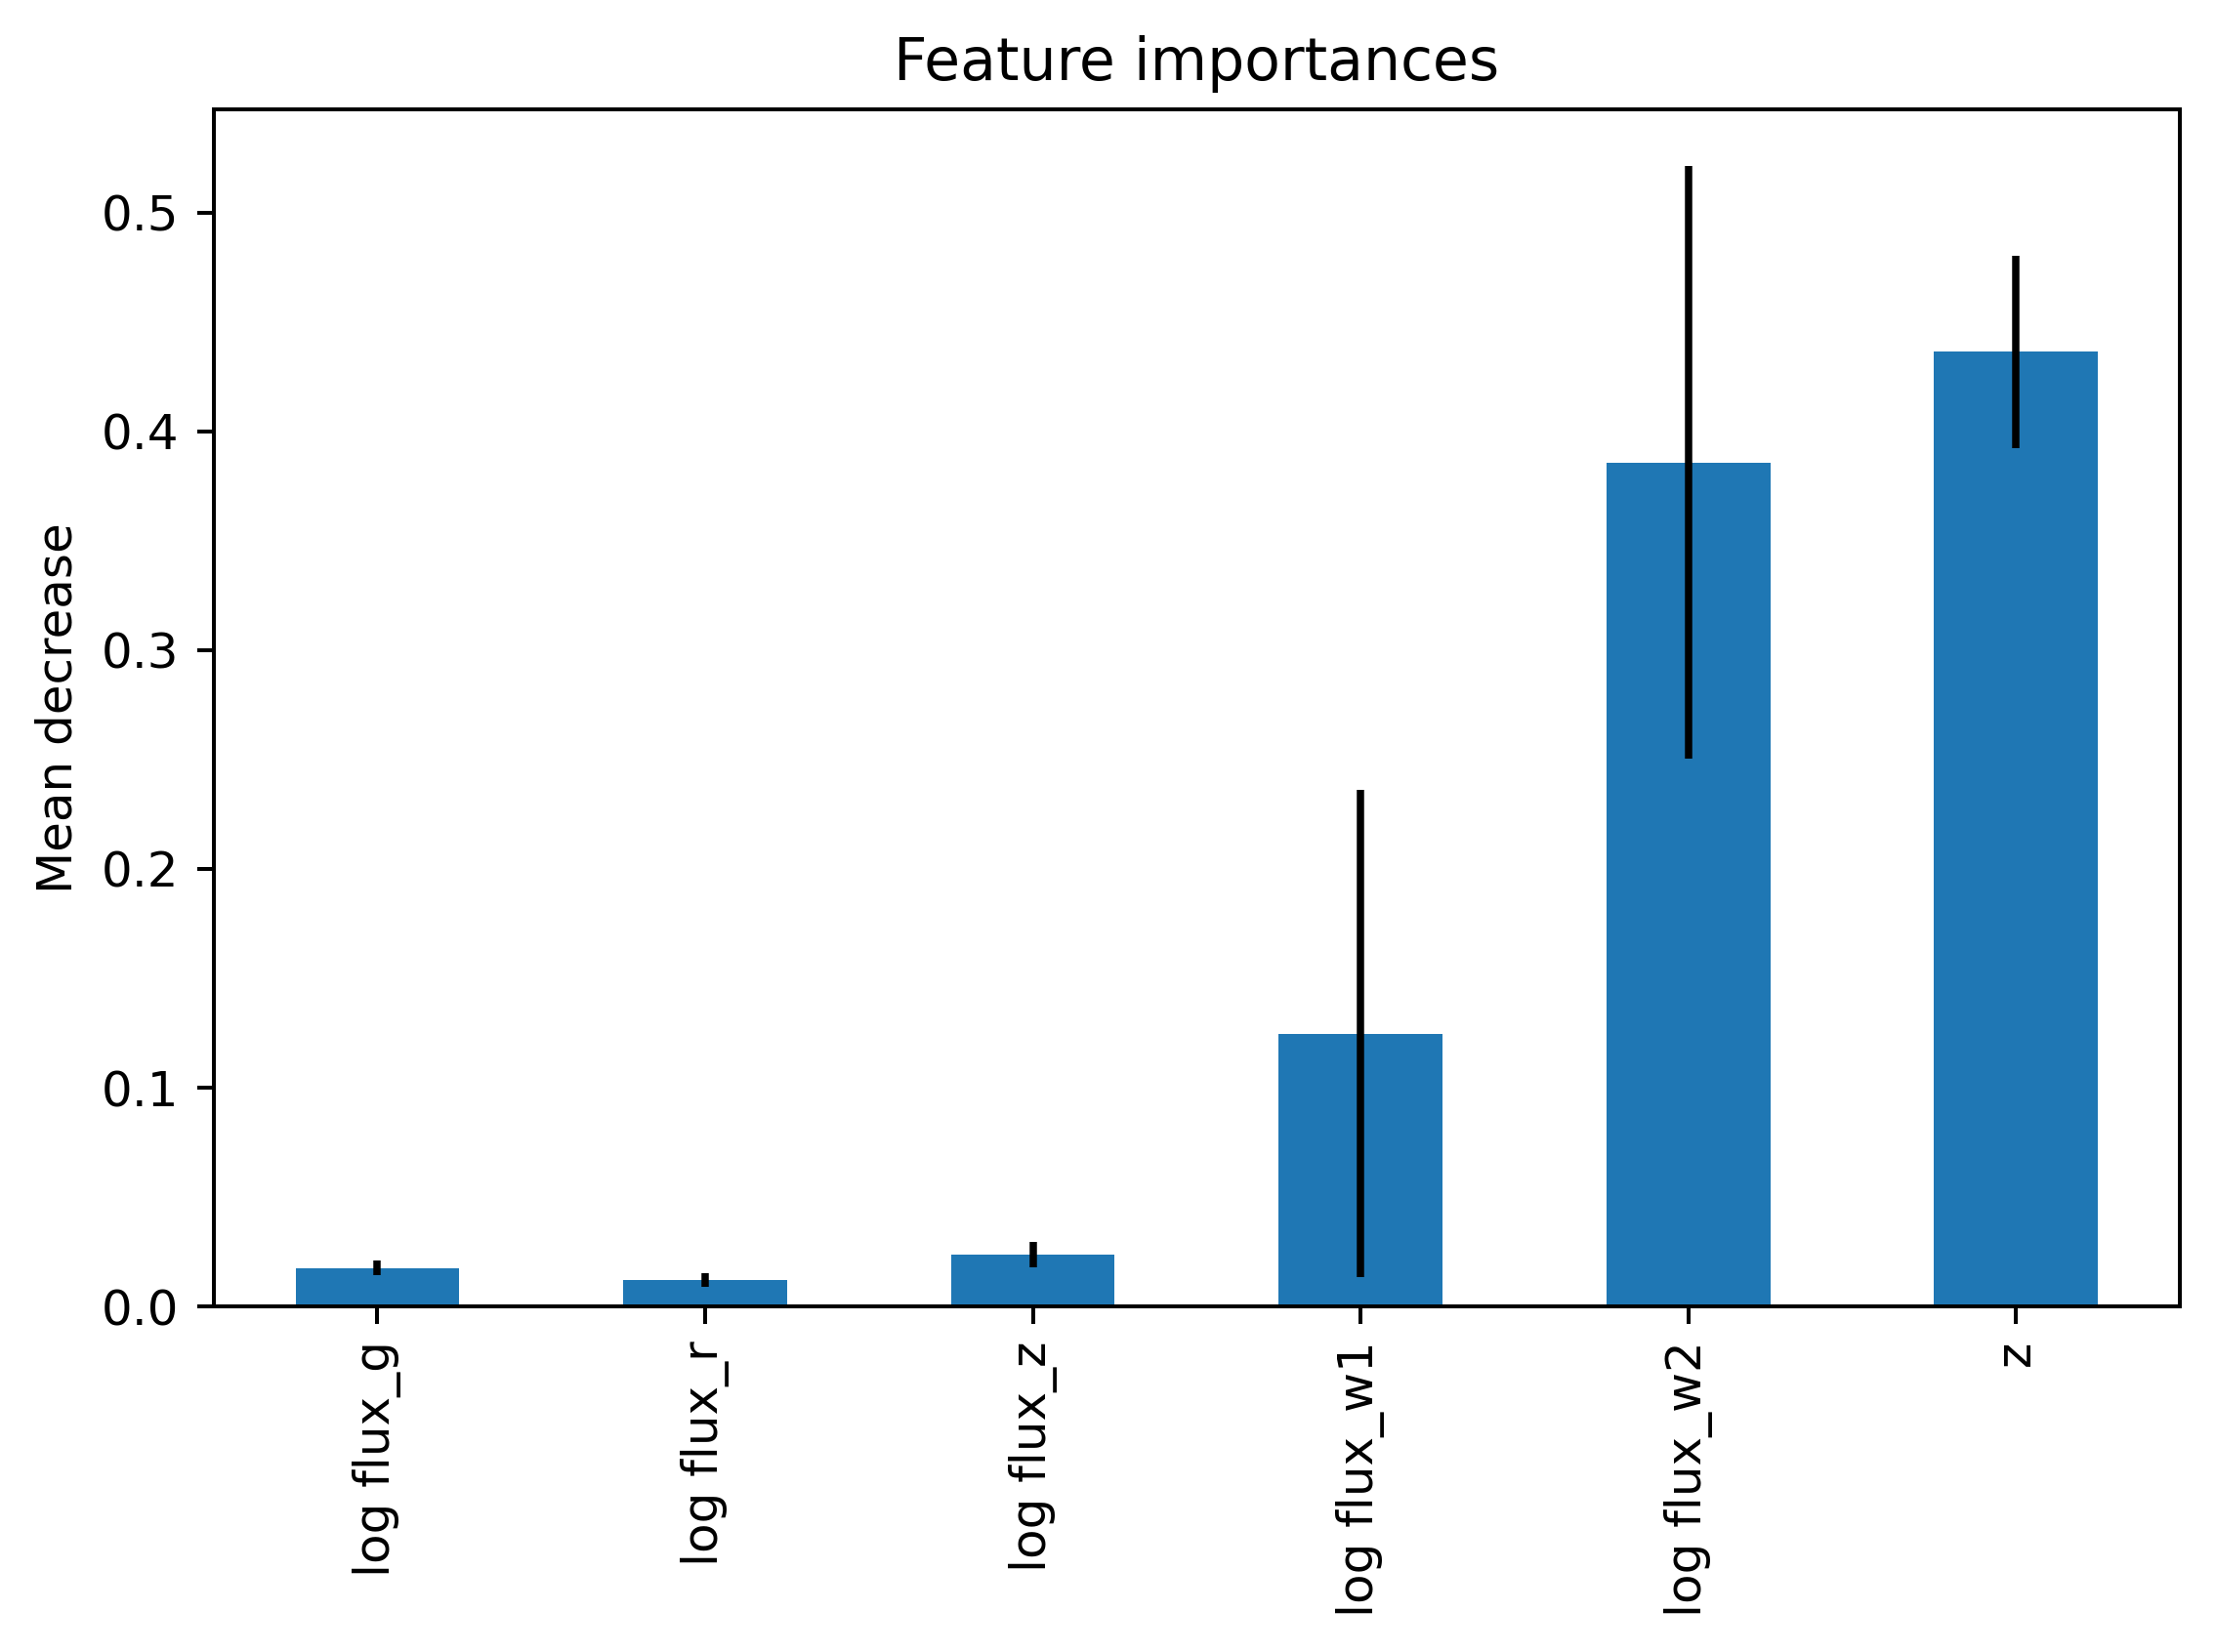

In [11]:
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z']
feature_names = [f"{i}" for i in props]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Adding a random column

In [13]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor_rdm = RandomForestRegressor(n_estimators=100, random_state=0)

random_column = np.random.rand(len(y_train)) #random column
X_train_extended = np.column_stack((X_train, random_column))
regressor_rdm.fit(X_train_extended, y_train)

X_test_extended = np.column_stack((X_test, np.random.rand(len(y_test))))
y_pred_extended = regressor_rdm.predict(X_test_extended)

r2, mse, pc = 1, mean_squared_error(y_test, y_pred), pearsonr(y_test, y_pred).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

R^2: 1
mse: 0.035719688968561494
Pearson correlation: 0.9507515018830839


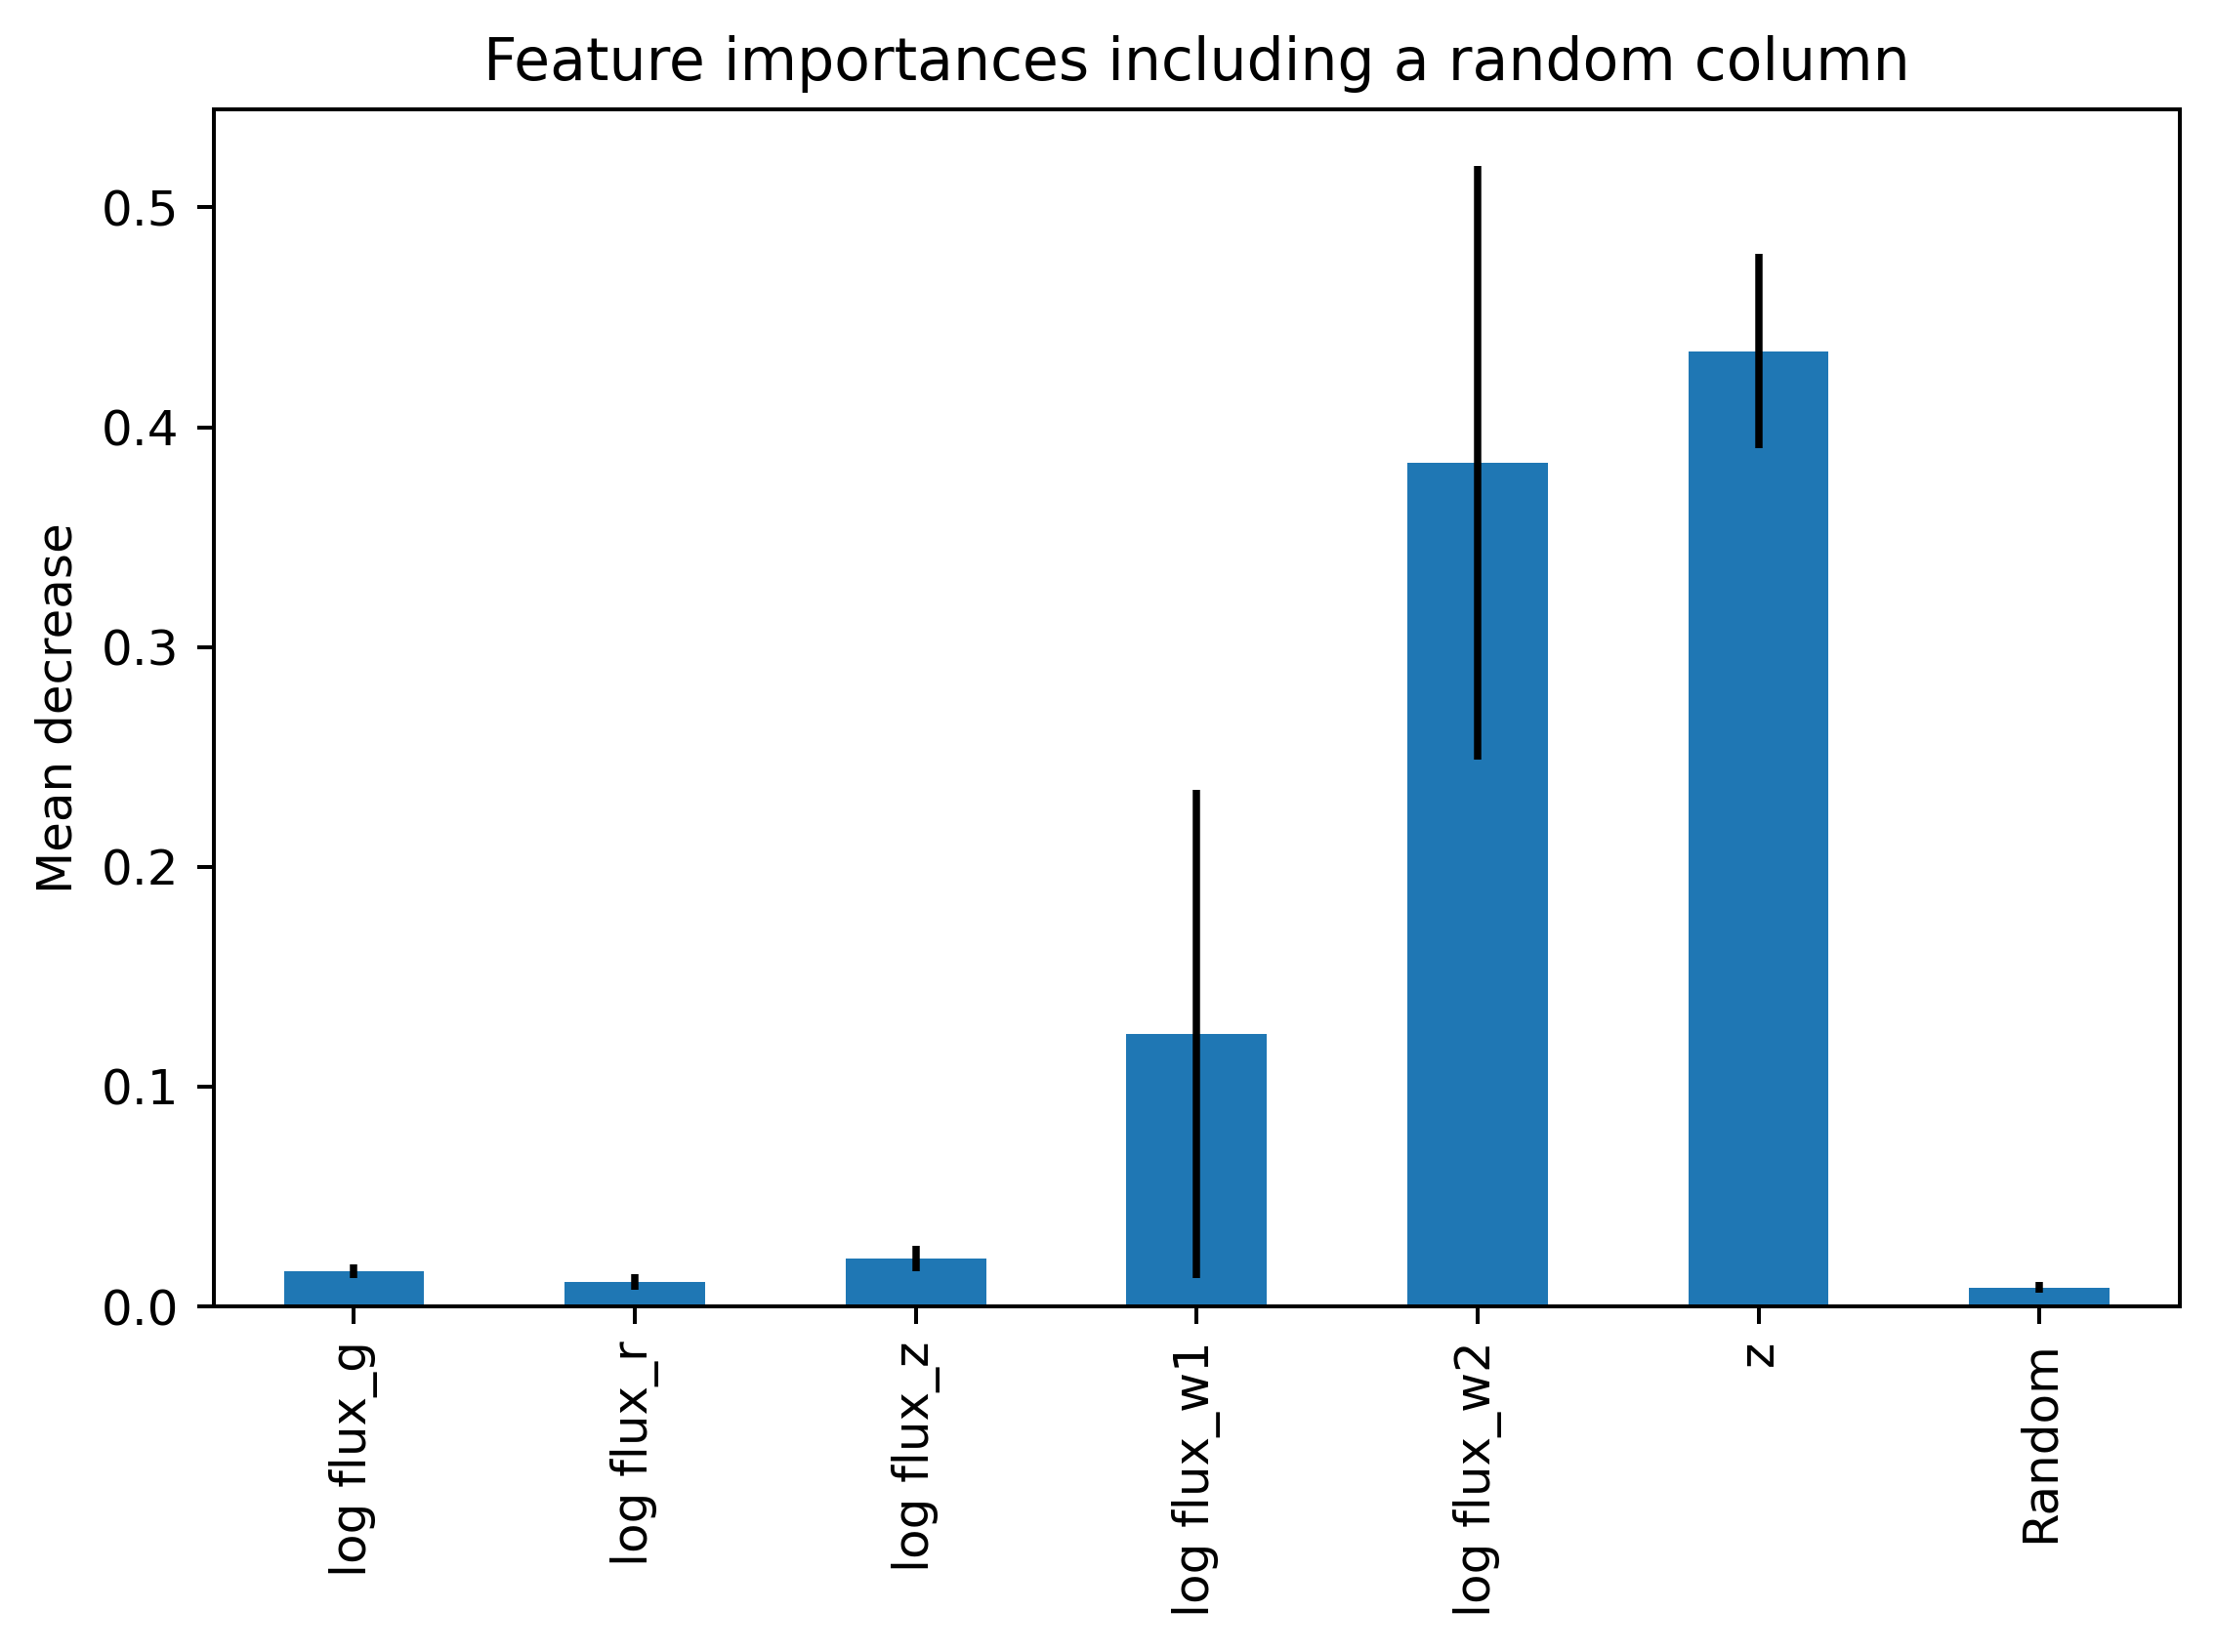

In [14]:
importances = regressor_rdm.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor_rdm.estimators_], axis=0)

props = ['log flux_g', 'log flux_r', 'log flux_z', 'log flux_w1', 'log flux_w2', 'z', 'Random']
feature_names = [f"{i}" for i in props[:-1]]
feature_names.append(props[-1])
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances including a random column")
ax.set_ylabel("Mean decrease")
fig.tight_layout()

Predictions in a different rosette

In [15]:
nodes, _, _ = graph_r(rosettes[2]) #Rosette 7
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
r2, mse, pc = model.score(X_test, y_pred), mean_squared_error(y_test, y_pred), pearsonr(y_test, y_pred).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

NameError: name 'model' is not defined

In [ ]:
nodes, _, _ = graph_r(rosettes[1]) #Rosette 6
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2, mse, pc = model.score(X_test, y_pred), mean_squared_error(y_test, y_pred), pearsonr(y_test, y_pred).statistic
print(f'R^2: {r2}')
print(f'mse: {mse}')
print(f'Pearson correlation: {pc}')

In [ ]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(f'Random Forest\n \nR^2: {round(r2)}\nMSE: {round(mse,2)}\nPearson correlation: {round(pc,2)}', y=1.12)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

X_test, y_test, y_pred = np.array(X_test), np.array(y_test), np.array(y_pred)

labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

for i in range(ncols):
    for j in range(nrows):
        axes[i, j].scatter(X_test[:,i*3+j], y_test, s=0.5, label='data')
        axes[i, j].scatter(X_test[:,i*3+j], y_pred, s=0.5, label='prediction')
        axes[i, j].legend()
        axes[i, j].set_ylabel(r'$\log M_{*}$')
        axes[i, j].set_xlabel(f'{labels[i*3+j]}')
        axes[i, j].grid()

plt.show()